In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from itertools import product
from dataclasses import dataclass
from collections import namedtuple, defaultdict
from tasks.markov import *
from models.base_models import *
from models.pos_encoder import *
from tasks.causal_graph import *
from config import *
from train import *
import figures.plot as plot
from util import memory_recall_probe, feedforward_probe
import seaborn as sns
import torch.utils.benchmark as benchmark
from tqdm.notebook import tqdm, trange

from figures.head_view import *

torch.set_printoptions(precision=2, sci_mode=False)

%load_ext autoreload
%autoreload 2

In [2]:
SEQ_LEN = 100
VOC_SIZE = 256
BATCH_SIZE = 256

config = Config(
        emb_dim=128,
        num_layers=2,
        num_heads=(1,1),
        identity_query=False,
        seq_len=SEQ_LEN,
        vocab_size=VOC_SIZE,
        batch_size=BATCH_SIZE,
        num_epochs=20000,
        eval_iter=1000,
        pos_enc='rpe',
        get_attn=100,
        mlp=(True,False),
        activation=(True,False),
        flash=False,
        ff_dim=128,
        layer_norm=False,
        ngram=2,
        learning_rate=1e-3,
        task_name="markov"
    )

sampler_config = MarkovSamplerConfig(seq_len=SEQ_LEN, vocab_size=VOC_SIZE, batch_size=BATCH_SIZE, rho=0.2, alpha=0.2, fixed=True, order=1,
                                     task_name="markov")

model = Transformer(config)
model = model.to(config.device)

config.device

'cuda'

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Loss plot saved at  loss_plots/s100p_rpe_l2h1_1v256markov_20250214_1917.png


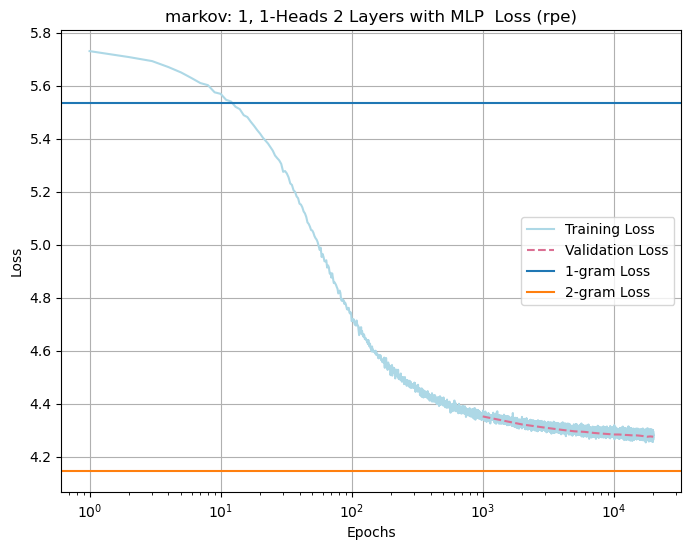

Creating images:   0%|          | 0/200 [00:00<?, ?it/s]

GIF saved at attns_plot/s100p_rpe_l2h1v256_L0H0markov_20250214_1918.gif
Folder 'attns' and its contents removed.


Creating images:   0%|          | 0/200 [00:00<?, ?it/s]

GIF saved at attns_plot/s100p_rpe_l2h1v256_L1H0markov_20250214_1918.gif
Folder 'attns' and its contents removed.


,


In [3]:
train_model_with_plot(model, config, sampler_config, show=True)